In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions

In [ ]:
# Load ResNet50 with pretrained weights from ImageNet
model = ResNet50(weights='imagenet')

In [ ]:
# Define the directory containing images
image_dir = "/content/"
image_files = [f for f in os.listdir(image_dir) if f.startswith("ILSVRC2012_test_") and f.endswith(".JPEG")]

In [ ]:
# Predict the class of the original image
predictions = model.predict(img_array)
decoded_predictions = decode_predictions(predictions, top=3)[0]
print("Original Image Predictions:")
for i in decoded_predictions:
    print(f"Class: {i[1]}, Probability: {i[2]:.2f}")

Original Image Predictions:
Class: German_shepherd, Probability: 0.99
Class: malinois, Probability: 0.01
Class: briard, Probability: 0.00


In [ ]:
# Create adversarial example using FGSM
def fgsm_attack(model, image, label, epsilon=0.01):
    image_tensor = tf.convert_to_tensor(image)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = model(image_tensor)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)

    gradients = tape.gradient(loss, image_tensor)
    signed_gradients = tf.sign(gradients)

    adversarial_image = image_tensor + epsilon * signed_gradients
    adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)
    return adversarial_image

In [ ]:
# Assuming the first class from predictions is the true label
true_label = np.zeros((1, 1000))
true_label[0][np.argmax(predictions)] = 1

# Generate adversarial example
epsilon = 0.01
adversarial_image = fgsm_attack(model, img_array, true_label, epsilon)

In [ ]:
# Make predictions on the adversarial example
adversarial_predictions = model.predict(adversarial_image)
decoded_adversarial_predictions = decode_predictions(adversarial_predictions, top=3)[0]
print("\nAdversarial Image Predictions:")
for i in decoded_adversarial_predictions:
    print(f"Class: {i[1]}, Probability: {i[2]:.2f}")


Adversarial Image Predictions:
Class: matchstick, Probability: 0.05
Class: nematode, Probability: 0.04
Class: screw, Probability: 0.03


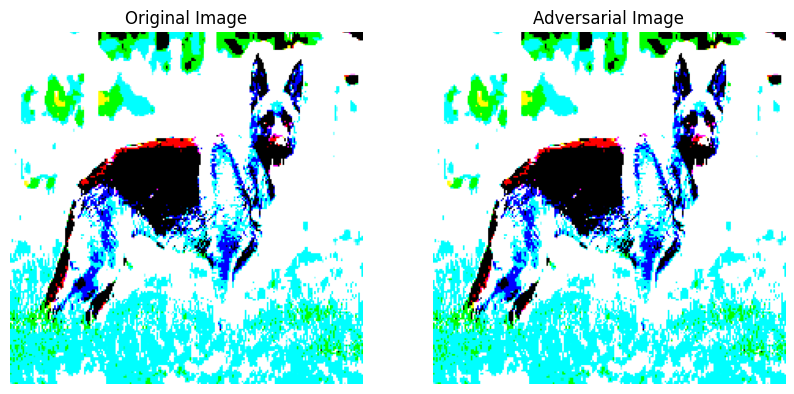

In [ ]:
# Visualize the original and adversarial images
def display_images(original, adversarial):
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(np.clip(original[0] + 1, 0, 2) / 2)  # Rescale to [0, 1]
    plt.title("Original Image")
    plt.axis('off')

    # Adversarial Image
    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(adversarial[0] + 1, 0, 2) / 2)  # Rescale to [0, 1]
    plt.title("Adversarial Image")
    plt.axis('off')

    plt.show()

# Display the images
display_images(img_array, adversarial_image)

In [ ]:
# DeepFool Attack
def deepfool(model, x, num_classes=10, overshoot=0.02, max_iter=50):
    x = tf.convert_to_tensor(x)
    f_image = model(x)
    label = tf.argmax(f_image, axis=1).numpy()[0]

    # One-hot encoding of the true label
    y_true = tf.one_hot(label, num_classes)
    f_label = f_image[0][label]

    perturbed_image = tf.identity(x)
    w = tf.zeros_like(x)

    for i in range(max_iter):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            f_image = model(perturbed_image)
            f_label = f_image[0][label]

        # Calculate gradients
        gradients = tape.gradient(f_label, perturbed_image)
        gradients = tf.reshape(gradients, (-1,))

        # Compute the optimal perturbation
        r = tf.linalg.norm(f_label, ord=1) / tf.linalg.norm(gradients, ord=1)
        perturbation = (r + overshoot) * tf.sign(gradients)
        perturbation = tf.reshape(perturbation, tf.shape(perturbed_image))

        # Update the perturbed image
        perturbed_image += perturbation

        # Check if the model misclassifies the perturbed image
        new_f_image = model(perturbed_image)
        new_label = tf.argmax(new_f_image, axis=1).numpy()[0]
        if new_label != label:
            break

    return perturbed_image.numpy()

In [ ]:
# Generate adversarial example using DeepFool
adversarial_image_1 = deepfool(model, img_array)

In [ ]:
# Make predictions on the adversarial example
adversarial_predictions = model.predict(adversarial_image)
decoded_adversarial_predictions = decode_predictions(adversarial_predictions, top=3)[0]
print("\nAdversarial Image Predictions:")
for i in decoded_adversarial_predictions:
    print(f"Class: {i[1]}, Probability: {i[2]:.2f}")


Adversarial Image Predictions:
Class: matchstick, Probability: 0.05
Class: nematode, Probability: 0.04
Class: screw, Probability: 0.03


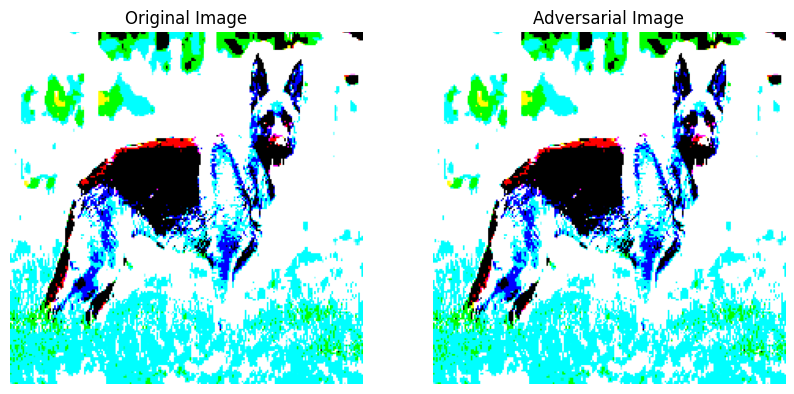

In [ ]:
# Visualize the original and adversarial images
def display_images(original, adversarial):
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(np.clip(original[0] + 1, 0, 2) / 2)  # Rescale to [0, 1]
    plt.title("Original Image")
    plt.axis('off')

    # Adversarial Image
    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(adversarial[0] + 1, 0, 2) / 2)  # Rescale to [0, 1]
    plt.title("Adversarial Image")
    plt.axis('off')

    plt.show()

# Display the images
display_images(img_array, adversarial_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Original Image Predictions for test_0.JPEG:
1: shower_curtain (0.15)
2: medicine_chest (0.06)
3: vase (0.05)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Adversarial Image Predictions for test_0.JPEG:
1: mosquito_net (0.25)
2: shower_curtain (0.04)
3: envelope (0.04)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Original Image Predictions for test_1.JPEG:
1: fireboat (0.22)
2: container_ship (0.15)
3: drilling_platform (0.04)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Adversarial Image Predictions for test_1.JPEG:
1: mosquito_net (0.06)
2: shower_curtain (0.03)
3: envelope (0.03)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Original Image Predictions for test_10.JPEG:
1: Petri_dish (0.11)
2: caldron (0.07)
3: tray (0.03)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Adversarial Image Predictions for test_10.JPEG:
1: mosquito_net (0.12)
2: envelope (0.05)
3: shower_curtain (0.04)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Original Image Pr

IndexError: index 5 is out of bounds for axis 0 with size 5

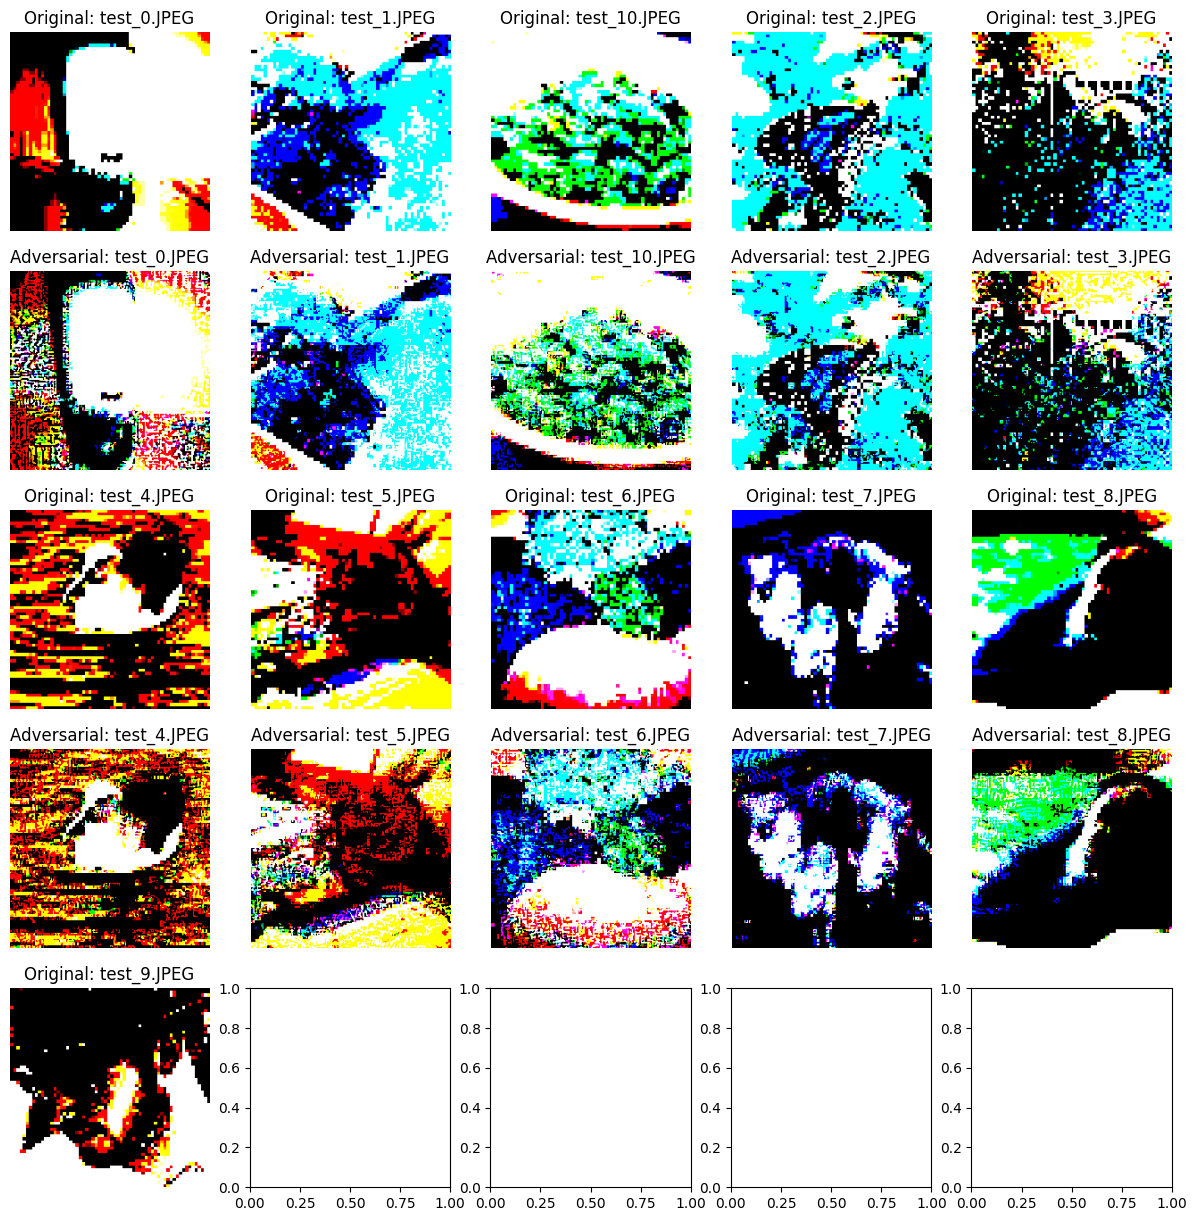

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import skew, kurtosis, entropy

# Load VGG19 model with ImageNet weights
model = VGG19(weights='imagenet')

# Define the directory containing images
image_dir = "/content/"
image_files = sorted([f for f in os.listdir(image_dir) if f.startswith("test_") and f.endswith(".JPEG")])

# FGSM attack function
def fgsm_attack(model, image, label, epsilon=0.01):
    image_tensor = tf.convert_to_tensor(image)
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = model(image_tensor)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradients = tape.gradient(loss, image_tensor)
    signed_gradients = tf.sign(gradients)
    adversarial_image = image_tensor + epsilon * signed_gradients
    adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)
    return adversarial_image.numpy()

# Lists to store images
original_images = []
adversarial_images = []
image_titles = []

epsilon = 15  # Perturbation strength

# Process each image
for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make predictions on the original image
    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=3)[0]

    print(f"\nOriginal Image Predictions for {img_file}:")
    for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
        print(f"{i + 1}: {label} ({score:.2f})")

    # Create one-hot encoded label
    true_label = np.zeros((1, 1000))
    true_label[0][np.argmax(predictions)] = 1

    # Generate adversarial image
    adversarial_image = fgsm_attack(model, img_array, true_label, epsilon)

    # Make predictions on adversarial image
    adversarial_predictions = model.predict(adversarial_image)
    decoded_adversarial_predictions = decode_predictions(adversarial_predictions, top=3)[0]

    print(f"\nAdversarial Image Predictions for {img_file}:")
    for i, (imagenet_id, label, score) in enumerate(decoded_adversarial_predictions):
        print(f"{i + 1}: {label} ({score:.2f})")

    # Store images for display
    original_images.append((img_array[0] + 1) / 2)  # Normalize for display
    adversarial_images.append((adversarial_image[0] + 1) / 2)
    image_titles.append(img_file)

# Display all images in a grid
num_images = len(original_images)
cols = 5  # Number of columns in the grid
rows = (num_images * 2 + cols - 1) // cols  # Adjust rows dynamically

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

for i in range(num_images):
    # Display original image
    ax = axes[i // cols * 2][i % cols]  # Row shift for adversarial images
    ax.imshow(original_images[i])
    ax.set_title(f"Original: {image_titles[i]}")
    ax.axis('off')

    # Display adversarial image
    ax = axes[i // cols * 2 + 1][i % cols]  # Shift to the next row for adversarial images
    ax.imshow(adversarial_images[i])
    ax.set_title(f"Adversarial: {image_titles[i]}")
    ax.axis('off')

# Adjust layout and show all images
plt.tight_layout()
plt.show()


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load VGG19 model with ImageNet weights
model = ResNet101(weights='imagenet')

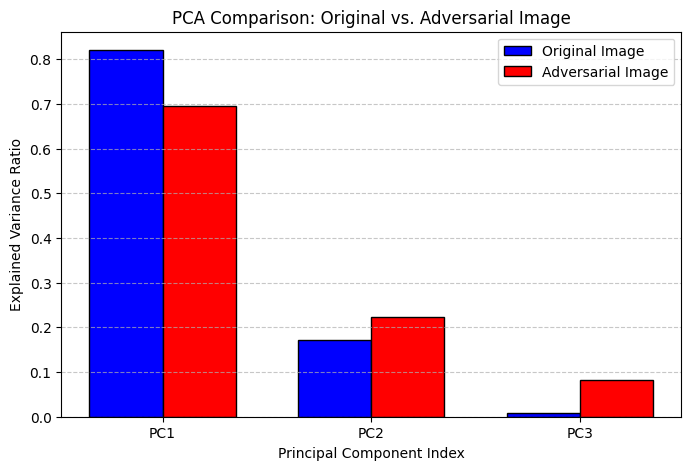

In [35]:
from sklearn.decomposition import PCA

# Load and preprocess the image
img_path = "/content/test_73.JPEG"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# FGSM Attack Function
def fgsm_attack(model, image, epsilon=0.01):
    image_tensor = tf.convert_to_tensor(image)
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = model(image_tensor)
        target_label = tf.one_hot(np.argmax(prediction.numpy()), 1000)
        target_label = tf.reshape(target_label, (1, 1000))
        loss = tf.keras.losses.categorical_crossentropy(target_label, prediction)

    gradients = tape.gradient(loss, image_tensor)
    signed_gradients = tf.sign(gradients)
    adversarial_image = image_tensor + epsilon * signed_gradients
    adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)
    return adversarial_image.numpy()

# Generate adversarial image
epsilon = 15
adversarial_image = fgsm_attack(model, img_array, epsilon)

# Function to apply PCA
def apply_pca(image, n_components=3):
    h, w, c = image.shape
    image_reshaped = image.reshape(h * w, c)
    pca = PCA(n_components=n_components)
    pca.fit(image_reshaped)
    return pca.explained_variance_ratio_

# Apply PCA
pca_original = apply_pca(img_array[0])
pca_adversarial = apply_pca(adversarial_image[0])

# Plot settings
bar_width = 0.35  # Width of each bar
indices = np.arange(len(pca_original))  # X-axis positions

plt.figure(figsize=(8, 5))
plt.bar(indices - bar_width/2, pca_original, width=bar_width, label="Original Image", color="blue", edgecolor='black')
plt.bar(indices + bar_width/2, pca_adversarial, width=bar_width, label="Adversarial Image", color="red", edgecolor='black')

plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Comparison: Original vs. Adversarial Image")
plt.xticks(indices, [f"PC{i+1}" for i in indices])  # Custom x-axis labels
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for better readability

plt.show()


In [33]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Load and preprocess the image
img_path = "/content/test_219.JPEG"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# FGSM Attack Function
def fgsm_attack(model, image, epsilon=0.01):
    image_tensor = tf.convert_to_tensor(image)
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = model(image_tensor)
        target_label = tf.one_hot(np.argmax(prediction.numpy()), 1000)
        target_label = tf.reshape(target_label, (1, 1000))
        loss = tf.keras.losses.categorical_crossentropy(target_label, prediction)

    gradients = tape.gradient(loss, image_tensor)
    signed_gradients = tf.sign(gradients)
    adversarial_image = image_tensor + epsilon * signed_gradients
    adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)
    return adversarial_image.numpy()

# Generate adversarial image
epsilon = 15
adversarial_image = fgsm_attack(model, img_array, epsilon)

# Function to apply PCA
def apply_pca(image, n_components=5):
    h, w, c = image.shape
    image_reshaped = image.reshape(h * w, c)
    pca = PCA(n_components=n_components)
    pca.fit(image_reshaped)
    return pca.explained_variance_ratio_, pca.explained_variance_ratio_.cumsum()

# Apply PCA
pca_original, cumulative_original = apply_pca(img_array[0])
pca_adversarial, cumulative_adversarial = apply_pca(adversarial_image[0])

# Plot settings
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PCA Variance Comparison
axes[0].bar(range(1, len(pca_original) + 1), pca_original, alpha=0.6, label="Original", color="blue")
axes[0].bar(range(1, len(pca_adversarial) + 1), pca_adversarial, alpha=0.6, label="Adversarial", color="red")
axes[0].set_xlabel("Principal Component Index")
axes[0].set_ylabel("Explained Variance Ratio")
axes[0].set_title("Explained Variance per Principal Component")
axes[0].legend()

# Cumulative Explained Variance
axes[1].plot(range(1, len(cumulative_original) + 1), cumulative_original, marker='o', label="Original", color="blue")
axes[1].plot(range(1, len(cumulative_adversarial) + 1), cumulative_adversarial, marker='s', label="Adversarial", color="red")
axes[1].set_xlabel("Number of Principal Components")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].set_title("Cumulative Explained Variance")
axes[1].legend()

plt.tight_layout()
plt.show()


ValueError: too many values to unpack (expected 2)